In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import joblib  # For model export

# Set random state for reproducibility
np.random.seed(42)

In [2]:
# Load the housing dataset
housing = pd.read_csv('../data/housing.csv')  # Adjust path if needed

# Basic info
print("Dataset shape:", housing.shape)
print("\nFirst 5 rows:")
print(housing.head())
print("\nMissing values:")
print(housing.isnull().sum())

Dataset shape: (20640, 10)

First 5 rows:
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  

Missing values:
longitude       

In [3]:
# Improvement: Impute missing values in total_bedrooms with median (common for this dataset)
imputer = SimpleImputer(strategy='median')
housing['total_bedrooms'] = imputer.fit_transform(housing[['total_bedrooms']])

print("Missing values after imputation:", housing.isnull().sum().sum())

Missing values after imputation: 0


In [4]:
# Create new features (kept same: per household metrics)
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

# Select features (exclude target)
features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
            'population', 'households', 'median_income', 'rooms_per_household',
            'bedrooms_per_room', 'population_per_household', 'ocean_proximity']
X = housing[features]
y = housing['median_house_value']

print("Features shape:", X.shape)
print("\nFeature names:", X.columns.tolist())

Features shape: (20640, 12)

Feature names: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household', 'ocean_proximity']


In [5]:
# Split the data (kept same ratio, added random_state)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (16512, 12)
Test shape: (4128, 12)


In [6]:
# One-hot encode ocean_proximity (pipeline for consistency)
categorical_features = ['ocean_proximity']
numeric_features = [col for col in X.columns if col != 'ocean_proximity']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Fit and transform
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Get feature names for reference
feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
print("Preprocessed feature names (total 15):", feature_names)
print("Train preprocessed shape:", X_train_preprocessed.shape)

Preprocessed feature names (total 15): ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']
Train preprocessed shape: (16512, 15)


In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
# --------------------------
# 1️⃣ Define a smaller, faster model for search
# --------------------------
rf = RandomForestRegressor(n_estimators=50, random_state=42)  # fewer trees for grid search

# --------------------------
# 2️⃣ Use RandomizedSearchCV instead of full GridSearch
# --------------------------
param_grid = {
    'max_features': [6, 8, 10, 12],
    'max_depth': [3, 10, None],
    'min_samples_split': [2, 14, 16],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_grid,
    n_iter=10,               # try 10 random combinations
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,               # use all CPU cores
    random_state=42
)

# --------------------------
# 3️⃣ Fit the model
# --------------------------
random_search.fit(X_train_preprocessed, y_train)

best_forest = random_search.best_estimator_
print("Best params:", random_search.best_params_)
print("Best CV MSE:", -random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'min_samples_split': 16, 'max_features': 6, 'max_depth': None, 'bootstrap': False}
Best CV MSE: 2374928798.4401503


In [11]:
# Predictions on test set
y_test_pred = best_forest.predict(X_test_preprocessed)

# Evaluation metrics (kept same)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test MSE: ${mse_test:,.2f}")
print(f"Test RMSE: ${rmse_test:,.2f}")
print(f"Test R²: {r2_test:.4f}")

# Improvement: Cross-validation on full train
cv_scores = cross_val_score(best_forest, X_train_preprocessed, y_train, cv=5, scoring='r2')
print(f"CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Test MSE: $2,344,695,839.94
Test RMSE: $48,422.06
Test R²: 0.8211
CV R²: 0.8222 (+/- 0.0085)


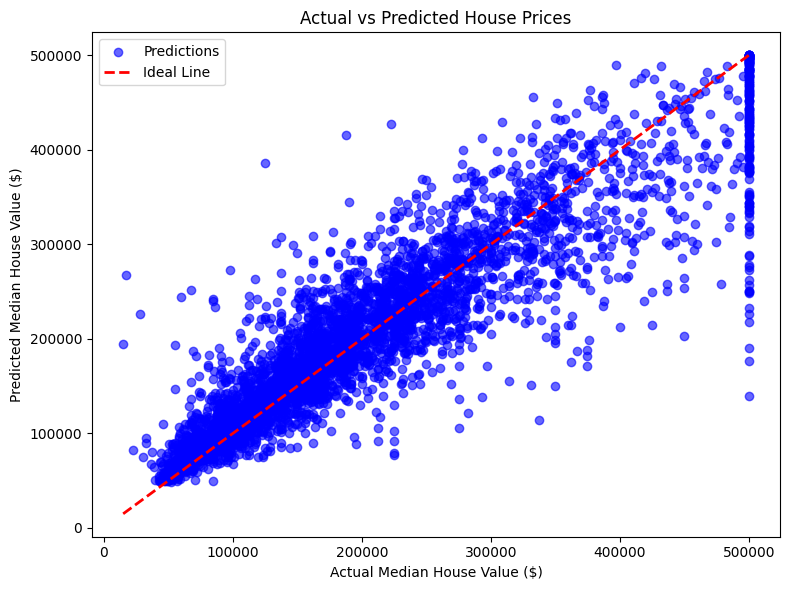

In [18]:
# Plot actual vs predicted
# Plot actual vs predicted with distinct colors and legend
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.6, label='Predictions')  # Blue for predicted points
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Line')  # Red dashed for actual-ideal match
plt.xlabel('Actual Median House Value ($)')
plt.ylabel('Predicted Median House Value ($)')
plt.title('Actual vs Predicted House Prices')
plt.legend()  # Add legend to distinguish elements
plt.tight_layout()
plt.show()

In [13]:
# Export for later use (kept, added preprocessor)
joblib.dump(best_forest, 'price_house_v2_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
print("Model and preprocessor exported successfully.")

Model and preprocessor exported successfully.


In [15]:
# Reload full data for samples (if not in memory)
housing_full = pd.read_csv('../data/housing.csv')

# Impute missing (same as training)
housing_full['total_bedrooms'] = imputer.fit_transform(housing_full[['total_bedrooms']])  # Reuse imputer

# Two sample records (rows 1 and 2, 0-indexed; exclude median_house_value) ---- > add the rows you want tested 
samples_raw = housing_full.iloc[[0, 1,2]][['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                                         'total_bedrooms', 'population', 'households', 'median_income',
                                         'ocean_proximity']]

# Engineer features (same as training)
samples_raw['rooms_per_household'] = samples_raw['total_rooms'] / samples_raw['households']
samples_raw['bedrooms_per_room'] = samples_raw['total_bedrooms'] / samples_raw['total_rooms']
samples_raw['population_per_household'] = samples_raw['population'] / samples_raw['households']

print("Raw samples (pre-one-hot):\n", samples_raw)

Raw samples (pre-one-hot):
    longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   

   population  households  median_income ocean_proximity  rooms_per_household  \
0       322.0       126.0         8.3252        NEAR BAY             6.984127   
1      2401.0      1138.0         8.3014        NEAR BAY             6.238137   
2       496.0       177.0         7.2574        NEAR BAY             8.288136   

   bedrooms_per_room  population_per_household  
0           0.146591                  2.555556  
1           0.155797                  2.109842  
2           0.129516                  2.802260  


In [17]:
# Load model and preprocessor
best_forest_loaded = joblib.load('price_house_v2_model.pkl')
preprocessor_loaded = joblib.load('preprocessor.pkl')

# Preprocess samples (same pipeline)
samples_preprocessed = preprocessor_loaded.transform(samples_raw)

# Predict
sample_predictions = best_forest_loaded.predict(samples_preprocessed)

# Results
print("\nSample Predictions:")
for i, (pred, row) in enumerate(zip(sample_predictions, samples_raw.iterrows())):
    idx, data = row
    print(f"\nSample {i+1} (original row {idx+1}):")
    print(f"  Predicted median house value: ${pred:,.2f}")
    print(f"  Key features: Longitude={data['longitude']}, Latitude={data['latitude']}, "
          f"Rooms/HH={data['rooms_per_household']:.2f}, Income={data['median_income']}, "
          f"Ocean Proximity={data['ocean_proximity']}")


Sample Predictions:

Sample 1 (original row 1):
  Predicted median house value: $429,443.42
  Key features: Longitude=-122.23, Latitude=37.88, Rooms/HH=6.98, Income=8.3252, Ocean Proximity=NEAR BAY

Sample 2 (original row 2):
  Predicted median house value: $394,033.29
  Key features: Longitude=-122.22, Latitude=37.86, Rooms/HH=6.24, Income=8.3014, Ocean Proximity=NEAR BAY

Sample 3 (original row 3):
  Predicted median house value: $386,292.71
  Key features: Longitude=-122.24, Latitude=37.85, Rooms/HH=8.29, Income=7.2574, Ocean Proximity=NEAR BAY
